 # Capa Silver - Transformación de Datos
 ## Sistema de Detección de Transacciones Fraudulentas  
 
 **Objetivo:** Transformar datos crudos en features para Machine Learning
 **Dataset:** 1.2M+ transacciones de tarjetas de crédito
 **Hallazgo clave:** 0.58% tasa de fraude (desbalance severo)


 ## 1. Conexión Segura a Snowflake


In [2]:
from snowflake.snowpark import Session
import getpass
import pandas as pd
import matplotlib.pyplot as plt

print(" Ingresa tus credenciales de Snowflake:")
user = input("Usuario: ")
password = getpass.getpass("Contraseña: ")
account = input("Account (ej: myfsmos.wlb40068): ")

connection_parameters = {
    "account": account,
    "user": user,
    "password": password,
    "warehouse": "COMPUTE_WH",
    "database": "CARD_TRANSACTION", 
    "schema": "SILVER"
}

try:
    session = Session.builder.configs(connection_parameters).create()
    print(" Conectado a Snowflake exitosamente!")
except Exception as e:
    print(f" Error de conexión: {e}")

 Ingresa tus credenciales de Snowflake:
 Conectado a Snowflake exitosamente!


 ## 2. Referencia: Hallazgos del Bronze 



**Resumen del EDA en Bronze:**
 - 1,296,675 transacciones totales
 - 7,506 fraudes (0.58%) - desbalance crítico
 - 0 valores nulos en columnas críticas  
 - Fraudes son 8x más grandes en promedio ($531 vs $67)
 - Datos de 2019-2020

## 3. Transformación 1: Limpieza Estructural

 ### Creación de tabla: TRANSACTIONS_STRUCTURED
 **Problemas solucionados:**
 - Nombres desordenados: "  walmart  " → "WALMART"
 - Fechas en formato crudo → TIMESTAMP
 - Categorización básica de transacciones

In [3]:
# Ejecutar transformación estructural
session.sql("""
CREATE OR REPLACE TABLE SILVER.TRANSACTIONS_STRUCTURED AS
SELECT 
    TRANS_NUM,
    CC_NUM,
    TRANS_DATE_TRANS_TIME AS TRANSACTION_TIMESTAMP,
    AMT AS AMOUNT,
    UPPER(TRIM(MERCHANT)) AS MERCHANT_CLEAN,
    UPPER(TRIM(CATEGORY)) AS CATEGORY_CLEAN,
    IS_FRAUD,
    CASE 
        WHEN IS_FRAUD = 1 THEN 'FRAUD'
        ELSE 'LEGITIMATE' 
    END AS TRANSACTION_TYPE
FROM CARD_TRANSACTION.BRONZE.RAW_TRANSACTIONS;
""").collect()

print(" Tabla TRANSACTIONS_STRUCTURED creada exitosamente")


 Tabla TRANSACTIONS_STRUCTURED creada exitosamente


In [4]:
# Verificación
df_sample = session.table("SILVER.TRANSACTIONS_STRUCTURED").limit(5).to_pandas()
print(" Muestra de datos limpios:")
display(df_sample[['MERCHANT_CLEAN', 'CATEGORY_CLEAN', 'TRANSACTION_TYPE', 'AMOUNT']])

 Muestra de datos limpios:


,MERCHANT_CLEAN,CATEGORY_CLEAN,TRANSACTION_TYPE,AMOUNT
0,"FRAUD_SCHUMM, BAUCH AND ONDRICKA",GROCERY_POS,LEGITIMATE,53.99
1,FRAUD_BOYER PLC,SHOPPING_NET,LEGITIMATE,286.71
2,"FRAUD_ROHAN, WHITE AND AUFDERHAR",MISC_NET,LEGITIMATE,315.95
3,FRAUD_BROWN PLC,MISC_NET,LEGITIMATE,193.19
4,"FRAUD_SCHUMM, BAUCH AND ONDRICKA",GROCERY_POS,LEGITIMATE,187.12


## 4. Transformación 2: Features Avanzados

 ### Creación de tabla: TRANSACTIONS_ENHANCED
 **Features agregados:**
 - Temporales: Hora, día de semana, mes
 - Categorización de montos por riesgo
 - Preparación para análisis de patrones ML

In [5]:
session.sql("""
CREATE OR REPLACE TABLE SILVER.TRANSACTIONS_ENHANCED AS
SELECT 
    *,
    HOUR(TRANSACTION_TIMESTAMP) AS HOUR_OF_DAY,
    DAYOFWEEK(TRANSACTION_TIMESTAMP) AS DAY_OF_WEEK,
    MONTH(TRANSACTION_TIMESTAMP) AS MONTH_OF_YEAR,
    CASE 
        WHEN AMOUNT < 10 THEN 'VERY_LOW'
        WHEN AMOUNT < 50 THEN 'LOW'
        WHEN AMOUNT < 200 THEN 'MEDIUM'
        WHEN AMOUNT < 1000 THEN 'HIGH'
        ELSE 'VERY_HIGH'
    END AS AMOUNT_CATEGORY
FROM SILVER.TRANSACTIONS_STRUCTURED;
""").collect()

print(" Tabla TRANSACTIONS_ENHANCED creada exitosamente")

 Tabla TRANSACTIONS_ENHANCED creada exitosamente


In [6]:
# Verificación de features
df_features = session.sql("""
SELECT 
    HOUR_OF_DAY,
    DAY_OF_WEEK,
    MONTH_OF_YEAR, 
    AMOUNT_CATEGORY,
    TRANSACTION_TYPE
FROM SILVER.TRANSACTIONS_ENHANCED 
LIMIT 10;
""").to_pandas()

print(" Muestra de features creados:")
display(df_features)

 Muestra de features creados:


,HOUR_OF_DAY,DAY_OF_WEEK,MONTH_OF_YEAR,AMOUNT_CATEGORY,TRANSACTION_TYPE
0,22,6,9,VERY_HIGH,LEGITIMATE
1,22,6,9,LOW,LEGITIMATE
2,22,6,9,MEDIUM,LEGITIMATE
3,22,6,9,LOW,LEGITIMATE
4,22,6,9,VERY_LOW,LEGITIMATE
5,22,6,9,LOW,LEGITIMATE
6,22,6,9,VERY_LOW,LEGITIMATE
7,22,6,9,LOW,LEGITIMATE
8,22,6,9,LOW,LEGITIMATE
9,22,6,9,LOW,LEGITIMATE



 ## 5. Transformación 3: Tabla Dimensional

### Creación de tabla: DIM_MERCHANTS
 **Propósito:** Análisis dimensional de comercios
  - Conteo de transacciones por merchant
 - Promedio de montos por categoría
  - Base para análisis de riesgo por comercio


In [7]:
session.sql("""
CREATE OR REPLACE TABLE SILVER.DIM_MERCHANTS AS
SELECT 
    MERCHANT_CLEAN,
    CATEGORY_CLEAN,
    COUNT(*) as transaction_count,
    AVG(AMOUNT) as avg_transaction_amount
FROM SILVER.TRANSACTIONS_ENHANCED
GROUP BY MERCHANT_CLEAN, CATEGORY_CLEAN;
""").collect()

print(" Tabla DIM_MERCHANTS creada exitosamente")


 Tabla DIM_MERCHANTS creada exitosamente


In [8]:
# Verificación dimensional
df_dim = session.table("SILVER.DIM_MERCHANTS").limit(5).to_pandas()
print(" Muestra de dimensión merchants:")
display(df_dim)


 Muestra de dimensión merchants:


,MERCHANT_CLEAN,CATEGORY_CLEAN,TRANSACTION_COUNT,AVG_TRANSACTION_AMOUNT
0,"FRAUD_JENKINS, HAUCK AND FRIESEN",GAS_TRANSPORT,2705,63.654969
1,FRAUD_KUPHAL-BARTOLETTI,MISC_NET,1297,79.676137
2,FRAUD_EICHMANN-RUSSEL,MISC_POS,1525,62.332308
3,FRAUD_EMARD INC,GAS_TRANSPORT,2641,63.741950
4,FRAUD_MURRAY-SMITHAM,GROCERY_POS,2510,118.319813


## 6. Validación y Calidad de Datos

### 6.1 Conteo final de registros

In [9]:
# Conteo de todas las tablas
counts = session.sql("""
SELECT 'TRANSACTIONS_STRUCTURED' as table_name, COUNT(*) as count 
FROM SILVER.TRANSACTIONS_STRUCTURED
UNION ALL
SELECT 'TRANSACTIONS_ENHANCED', COUNT(*) 
FROM SILVER.TRANSACTIONS_ENHANCED
UNION ALL  
SELECT 'DIM_MERCHANTS', COUNT(*)
FROM SILVER.DIM_MERCHANTS;
""").to_pandas()

print(" Conteo final de tablas:")
display(counts)

 Conteo final de tablas:


,TABLE_NAME,COUNT
0,TRANSACTIONS_STRUCTURED,1296675
1,TRANSACTIONS_ENHANCED,1296675
2,DIM_MERCHANTS,700


### 6.2 Distribución de fraudes vs legítimas

In [10]:
# Análisis de distribución
distribution = session.sql("""
SELECT 
    TRANSACTION_TYPE,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
FROM SILVER.TRANSACTIONS_ENHANCED
GROUP BY TRANSACTION_TYPE;
""").to_pandas()

print(" Distribución de transacciones:")
display(distribution)

 Distribución de transacciones:


,TRANSACTION_TYPE,COUNT,PERCENTAGE
0,FRAUD,7506,0.58
1,LEGITIMATE,1289169,99.42


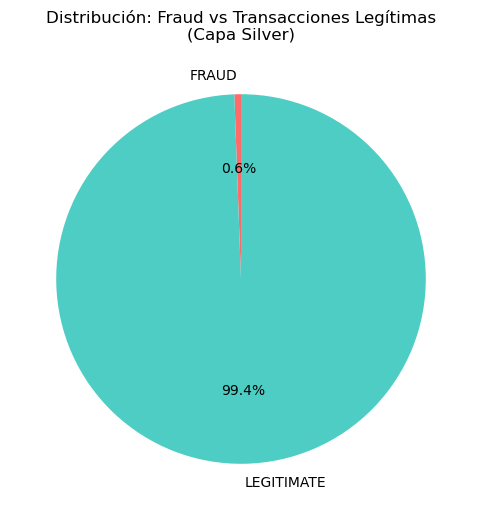

In [11]:
# Gráfico de distribución
plt.figure(figsize=(8, 6))
colors = ['#ff6b6b', '#4ecdc4']
plt.pie(distribution['COUNT'], labels=distribution['TRANSACTION_TYPE'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribución: Fraud vs Transacciones Legítimas\n(Capa Silver)')
plt.show()

### 6.3 Análisis de montos: Fraud vs Legítimas


In [12]:
# Comparación de montos
amount_analysis = session.sql("""
SELECT 
    TRANSACTION_TYPE,
    MIN(AMOUNT) as min_amount,
    MAX(AMOUNT) as max_amount,
    AVG(AMOUNT) as avg_amount,
    COUNT(*) as count
FROM SILVER.TRANSACTIONS_ENHANCED
GROUP BY TRANSACTION_TYPE;
""").to_pandas()

print("Análisis comparativo de montos:")
display(amount_analysis)

Análisis comparativo de montos:


,TRANSACTION_TYPE,MIN_AMOUNT,MAX_AMOUNT,AVG_AMOUNT,COUNT
0,FRAUD,1.06,1376.04,531.320092,7506
1,LEGITIMATE,1.00,28948.90,67.667110,1289169


## 7. Hallazgos y Patrones Descubiertos

### 7.1 Patrón clave: Fraudes son más grandes

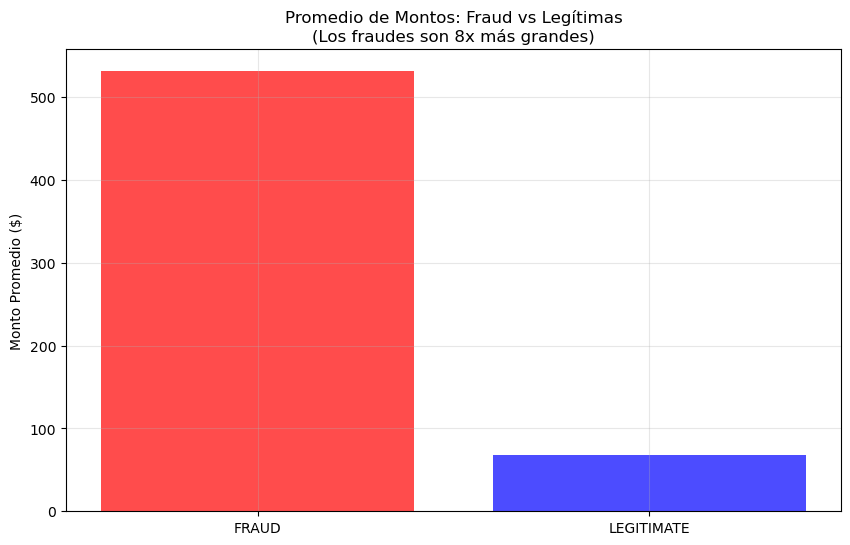

In [13]:
# Gráfico comparativo de montos
plt.figure(figsize=(10, 6))
plt.bar(amount_analysis['TRANSACTION_TYPE'], amount_analysis['AVG_AMOUNT'], 
        color=['red', 'blue'], alpha=0.7)
plt.title('Promedio de Montos: Fraud vs Legítimas\n(Los fraudes son 8x más grandes)')
plt.ylabel('Monto Promedio ($)')
plt.grid(True, alpha=0.3)
plt.show()

### 7.2 Distribución por categorías de monto


In [14]:
# Análisis por categoría de monto
amount_cat_analysis = session.sql("""
SELECT 
    AMOUNT_CATEGORY,
    TRANSACTION_TYPE,
    COUNT(*) as count
FROM SILVER.TRANSACTIONS_ENHANCED
GROUP BY AMOUNT_CATEGORY, TRANSACTION_TYPE
ORDER BY 
    CASE AMOUNT_CATEGORY
        WHEN 'VERY_LOW' THEN 1
        WHEN 'LOW' THEN 2
        WHEN 'MEDIUM' THEN 3
        WHEN 'HIGH' THEN 4
        WHEN 'VERY_HIGH' THEN 5
    END,
    TRANSACTION_TYPE;
""").to_pandas()

print("Distribución por categoría de monto:")
display(amount_cat_analysis)

Distribución por categoría de monto:


,AMOUNT_CATEGORY,TRANSACTION_TYPE,COUNT
0,VERY_LOW,FRAUD,525
1,VERY_LOW,LEGITIMATE,335193
2,LOW,FRAUD,1082
3,LOW,LEGITIMATE,335414
4,MEDIUM,FRAUD,195
5,MEDIUM,LEGITIMATE,562336
6,HIGH,FRAUD,4754
7,HIGH,LEGITIMATE,53239
8,VERY_HIGH,FRAUD,950
9,VERY_HIGH,LEGITIMATE,2987


## 8. Conclusiones y Preparación para Gold

###  Transformaciones Completadas:
 
 1. **Limpieza Estructural**: Datos crudos → datos estandarizados
 2. **Feature Engineering**: Características para patrones temporales y de monto
 3. **Modelado Dimensional**: Base para análisis de comercios
 
 ###  Hallazgos Clave:
 
 - **Desbalance crítico**: 0.58% fraudes vs 99.42% legítimas
 - **Patrón de monto**: Fraudes 8x más grandes en promedio ($531 vs $67)
  - **Calidad excelente**: 0 valores nulos en columnas críticas
 
 ###  Preparado para Gold:
 
 - **Tablas listas** para entrenamiento de modelos ML
 - **Features temporales** para detección de patrones
 - **Categorías de riesgo** para priorización
 
 **Entregable:** 3 tablas Silver funcionales y validadas

In [15]:
# Verificación final
print(" CAPA SILVER COMPLETADA EXITOSAMENTE")
print(" Tablas creadas: 3")
print(" Datos validados: 1,296,675 registros")
print(" Listo para capa Gold (Machine Learning)")

 CAPA SILVER COMPLETADA EXITOSAMENTE
 Tablas creadas: 3
 Datos validados: 1,296,675 registros
 Listo para capa Gold (Machine Learning)
